In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt

from EventPreProcess import EventPreProcess
from dvs_msgs.msg import EventArray
from std_msgs.msg import Float64, Bool
from geometry_msgs.msg import Pose, Vector3, PoseStamped

In [23]:
#parameters of processing
frequency = 10 #Hz
bag_file_name = 'tactile_sensing_data/17_point_data_estimation.bag'
h5_file_name = '17_point_single_frame_processed_data_10_Hz.hdf5'
time_window_size = 15
examples_per_edge = 3

In [6]:
bag_file = rosbag.Bag(bag_file_name)

events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []

#generate labels
possible_angle = [0.1, 0.25]
N_examples = 9
list_of_rotations = [[0, 0, 0]]

for i in range(1, N_examples):
    theta = i * 2 * math.pi/(N_examples - 1)
    for phi in possible_angle:
        rx = phi * math.cos(theta)
        ry = phi * math.sin(theta)
        rotvec = [rx, ry, 0]
        list_of_rotations.append(rotvec)

print(list_of_rotations)


[[0, 0, 0], [0.07071067811865477, 0.07071067811865475, 0], [0.1767766952966369, 0.17677669529663687, 0], [6.123233995736766e-18, 0.1, 0], [1.5308084989341915e-17, 0.25, 0], [-0.07071067811865475, 0.07071067811865477, 0], [-0.17677669529663687, 0.1767766952966369, 0], [-0.1, 1.2246467991473533e-17, 0], [-0.25, 3.061616997868383e-17, 0], [-0.07071067811865477, -0.07071067811865475, 0], [-0.17677669529663692, -0.17677669529663687, 0], [-1.8369701987210297e-17, -0.1, 0], [-4.592425496802574e-17, -0.25, 0], [0.07071067811865474, -0.07071067811865477, 0], [0.17677669529663684, -0.17677669529663692, 0], [0.1, -2.4492935982947065e-17, 0], [0.25, -6.123233995736766e-17, 0]]


In [7]:
#parse rosbag

for topic, msg, t in bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle']):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())

In [8]:
#interpolate
f = interp1d(contact_case_ts, contact_case, kind='previous')
contact_case_ts_int = range(min(contact_case_ts), max(contact_case_ts), int(1e9/frequency))
contact_case_int = f(contact_case_ts_int)

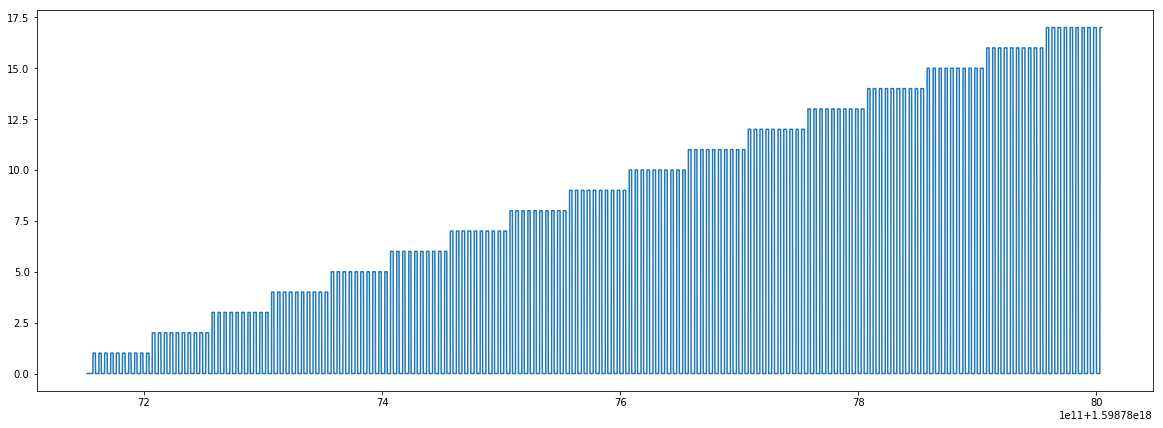

8521


In [13]:
plt.figure(figsize=(20,7))
plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))

In [14]:
#Generate frames and store in h5 file
hf = h5py.File(h5_file_name, 'w')
hf.create_dataset('contact_status', data=contact_case_int)
hf.create_dataset('time_steps', data=contact_case_ts_int)

set_size = 1000
unprocessed_events = np.copy(events)

for i in range(0, len(contact_case_ts_int), set_size):
    start_idx=i
    end_idx=min([len(contact_case_ts_int), i+set_size])

    #[event_frames, unprocessed_events] = EventPreProcess.ConcatenateEvents(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    [event_frames, unprocessed_events] = EventPreProcess.generateFrames(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    #write data
    if i==0:
        print(np.shape(event_frames))
        hf.create_dataset('event_images', data=event_frames, maxshape=(None,None, None, None))
    else:
        hf['event_images'].resize(len(hf['event_images']) + len(event_frames), axis=0)
        hf["event_images"][-len(event_frames):] = event_frames
    del event_frames

hf.close()

 finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 47
Percentage finished: 48
Percentage finished: 48
Percentage finished: 48
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 49
Percentage finished: 50
Percentage finished: 50
Percentage finished: 51
Percentage finished: 51
Pe

In [15]:

hf = h5py.File(h5_file_name, 'r+')
print('number of event images: {}'.format(len(hf['event_images'])))
hf.close()

number of event images: 8521


In [28]:
#Find rise/drop time and create windows accordingle
edge_locations = np.where(np.abs(np.diff(contact_case_int))>0)
edge_locations = np.array(edge_locations)[0].tolist()
print(edge_locations)

#Divide the data set into windows

def extract_edge_data(hf_file, edge_index_list, n_examples_per_edge=examples_per_edge, window_size=time_window_size, n_classes=18):
    for i in range(len(edge_index_list)):
        index = edge_index_list[i]

        for j in range(n_examples_per_edge):
            if hf_file['contact_status'][index+1] == 0:
                #fall edge case
                start_index = max([0, math.floor(index+5)])
                end_index = start_index + window_size               
            else:
                #rise edge case
                start_index = max([0, math.floor(index-window_size/2)])
                end_index = start_index + window_size

            if end_idx <= len(hf_file['contact_status']):
                reference_idx = range(int(start_index), int(end_index))
                one_hot_vector = [0] * n_classes
                one_hot_vector[int(hf_file['contact_status'][end_index])] = 1
                
                if not ('ex_input_image_idx' in hf_file.keys()):
                    hf_file.create_dataset('ex_input_image_idx', data=[reference_idx], maxshape=(None,None))
                    hf_file.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
                else:
                    hf_file['ex_input_image_idx'].resize(len(hf_file['ex_input_image_idx']) + 1, axis=0)
                    hf_file["ex_input_image_idx"][len(hf_file['ex_input_image_idx'])-1] = reference_idx

                    hf_file['ex_output'].resize(len(hf_file['ex_output']) + 1, axis=0)
                    hf_file["ex_output"][len(hf_file['ex_output'])-1] = one_hot_vector

[47, 68, 97, 117, 145, 167, 196, 217, 243, 267, 295, 317, 347, 367, 397, 417, 447, 467, 497, 518, 545, 568, 596, 618, 646, 668, 694, 718, 745, 767, 796, 818, 845, 867, 897, 918, 944, 968, 994, 1018, 1047, 1067, 1097, 1117, 1147, 1167, 1197, 1219, 1248, 1268, 1297, 1319, 1348, 1368, 1396, 1419, 1448, 1469, 1497, 1518, 1547, 1567, 1597, 1618, 1645, 1668, 1695, 1719, 1748, 1769, 1798, 1818, 1846, 1869, 1896, 1918, 1945, 1968, 1996, 2019, 2048, 2069, 2097, 2118, 2146, 2169, 2198, 2219, 2248, 2269, 2296, 2319, 2348, 2369, 2397, 2419, 2448, 2468, 2498, 2518, 2546, 2569, 2598, 2618, 2648, 2668, 2699, 2718, 2749, 2770, 2798, 2820, 2849, 2870, 2899, 2919, 2949, 2971, 3000, 3019, 3048, 3070, 3099, 3120, 3146, 3169, 3195, 3220, 3249, 3270, 3299, 3319, 3347, 3370, 3399, 3419, 3449, 3470, 3497, 3520, 3549, 3570, 3596, 3620, 3649, 3669, 3699, 3719, 3750, 3770, 3798, 3820, 3850, 3870, 3899, 3920, 3948, 3970, 3997, 4020, 4049, 4070, 4099, 4119, 4149, 4171, 4197, 4221, 4248, 4270, 4300, 4321, 4350, 437

In [29]:
#Divide the data set into windows

def create_dataset(hf_file, time_steps=50, n_classes=18):
    for i in range(time_steps, len(hf_file['event_images']) - time_steps):
        if (i%1000) == 0:
            print(i/float(len(hf_file['event_images'])))
        reference_idx = range(i-time_steps+1,i+1)
        one_hot_vector = [0] * n_classes
        one_hot_vector[int(hf_file['contact_status'][i])] = 1
        
        if i==time_steps:
            hf_file.create_dataset('ex_input_image_idx', data=[reference_idx], maxshape=(None,None))
            hf_file.create_dataset('ex_output', data=[one_hot_vector], maxshape=(None, None))
        else:
            hf_file['ex_input_image_idx'].resize(len(hf_file['ex_input_image_idx']) + 1, axis=0)
            hf_file["ex_input_image_idx"][len(hf_file['ex_input_image_idx'])-1] = reference_idx

            hf_file['ex_output'].resize(len(hf_file['ex_output']) + 1, axis=0)
            hf_file["ex_output"][len(hf_file['ex_output'])-1] = one_hot_vector

In [31]:
hf = h5py.File(h5_file_name, 'r+')
extract_edge_data(hf, edge_locations)
hf.close()

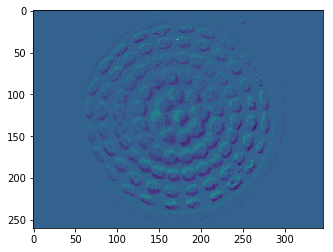

In [60]:
#Visualize events at switching states
hf = h5py.File(h5_file_name, 'r+')
indx = 90
plt.imshow(hf['event_images'][edge_locations[indx]][:,:,0])
plt.show
hf.close()

[507, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


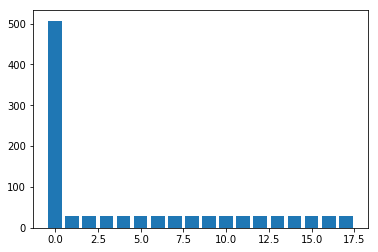

In [63]:
#analyze classes
hf = h5py.File(h5_file_name, 'r+')
counter = [0] * 18

for i in range(len(hf['ex_output'])):
    idx = list(hf['ex_output'][i]).index(1)
    counter[idx] = counter[idx] + 1

print(counter)
plt.bar(range(0,18),counter)
hf.close()

In [64]:
#Equalize representation of classes
hf = h5py.File(h5_file_name, 'r+')
def equalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(len(hf_file['ex_output'])):
        idx = list(hf['ex_output'][i]).index(1)
        
        if (np.random.rand() < (float(min(counter)) / counter[idx])):
            if 'ex_input_image_idx_equalized' in hf_file.keys():
                hf_file['ex_input_image_idx_equalized'].resize(len(hf_file['ex_input_image_idx_equalized']) + 1, axis=0)
                hf_file["ex_input_image_idx_equalized"][len(hf_file['ex_input_image_idx_equalized'])-1] = hf_file['ex_input_image_idx'][i]

                hf_file['ex_output_equalized'].resize(len(hf_file['ex_output_equalized']) + 1, axis=0)
                hf_file["ex_output_equalized"][len(hf_file['ex_output_equalized'])-1] = hf['ex_output'][i]
            else:
                hf_file.create_dataset('ex_input_image_idx_equalized', data=[hf_file['ex_input_image_idx'][i]], maxshape=(None,None))
                hf_file.create_dataset('ex_output_equalized', data=[hf_file['ex_output'][i]], maxshape=(None, None))

equalize_representation(hf, counter)

[26, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]


<Container object of 18 artists>

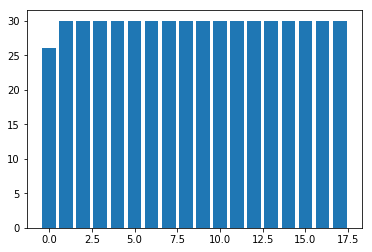

In [65]:
new_counter = [0] * 18

for i in range(len(hf['ex_output_equalized'])):
    idx = list(hf['ex_output_equalized'][i]).index(1)
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,18),new_counter)

In [66]:
print(len(hf['ex_output_equalized']))

536


In [67]:
hf.close()

In [30]:
hf = h5py.File(h5_file_name, 'r+')
del hf['ex_input_image_idx'] 
del hf['ex_output']
hf.close()

KeyError: "Couldn't delete link (callback link pointer is NULL (specified link may be '.' or not exist))"

In [33]:
print(np.mean(hf['event_images'][:,:,:,0]))
print(np.std(hf['event_images'][:,:,:,0]))
print(np.max(hf['event_images'][:,:,:,0]))
print(np.min(hf['event_images'][:,:,:,0]))


0.0008835273
0.031460017
21.0
0.0
